<h1><b>1 <span style='color:#f34e26'>|</span> 模型介绍</b></h1>

## 1.1 算法简介

XGBoost(Extreme Gradient Boosting),即一种高效的梯度提升决策树算法。他在原有的GBDT基础上进行了改进，使得模型效果得到大大提升。作为一种前向加法模型，他的核心是采用集成思想——Boosting思想，将多个弱学习器通过一定的方法整合为一个强学习器。即用多棵树共同决策，并且用每棵树的结果都是目标值与之前所有树的预测结果之差 并将所有的结果累加即得到最终的结果，以此达到整个模型效果的提升。

XGBoost是由多棵CART(Classification And Regression Tree)，即分类回归树组成，因此他可以处理分类回归等问题。

## 1.2 数学原理
### 1.2.1 目标函数

我们知道 XGBoost 是由 k 个基模型组成的一个加法运算式：

$$\hat{y}_i=\sum_{t=1}^{k}\ f_t(x_i) \\$$

其中 $f_{k}$ 为第 k 个基模型， $\hat{y}_i$ 为第 i 个样本的预测值。

损失函数可由预测值 $\hat{y}_i$ 与真实值 $y_i$ 进行表示：

$$L=\sum_{i=1}^n l( y_i, \hat{y}_i) \\$$

其中 n 为样本数量。

我们知道模型的预测精度由模型的偏差和方差共同决定，损失函数代表了模型的偏差，想要方差小则需要简单的模型，所以目标函数由模型的损失函数 L 与抑制模型复杂度的正则项 $\Omega$ 组成，所以我们有：

$$Obj =\sum_{i=1}^n l(\hat{y}_i, y_i) + \sum_{t=1}^k \Omega(f_t) \\$$

$\Omega$ 为模型的正则项，由于 XGBoost 支持决策树也支持线性模型，所以这里再不展开描述。

我们知道 boosting 模型是前向加法，以第 t 步的模型为例，模型对第 i 个样本 $x_{i}$ 的预测为：

$$\hat{y}_i^t= \hat{y}_i^{t-1} + f_t(x_i) \\$$

其中 $\hat{y}_i^{t-1}$ 由第 t-1 步的模型给出的预测值，是已知常数，$f_t(x_i)$ 是我们这次需要加入的新模型的预测值，此时，目标函数就可以写成：

$$\begin{align} Obj^{(t)} &= \sum_{i=1}^nl(y_i, \hat{y}_i^t) + \sum_{i=1}^t\Omega(f_i) \\ &= \sum_{i=1}^n l\left(y_i, \hat{y}_i^{t-1} + f_t(x_i) \right) + \sum_{i=1}^t \Omega(f_i) \end{align} \\$$

求此时最优化目标函数，就相当于求解$f_t(x_i)$。

泰勒公式是将一个在 $x=x_0$ 处具有 n 阶导数的函数 $f(x)$ 利用关于$ x-x_0 $的 n 次多项式来逼近函数的方法，若函数$ f(x) $在包含$ x_0 $的某个闭区间 $[a,b]$ 上具有 n 阶导数，且在开区间 $(a,b) $上具有 n+1 阶导数，则对闭区间$ [a,b] $上任意一点 x 有$ \displaystyle f(x)=\sum_{i=0}^{n}\frac{f^{(i)}(x_0)}{i!}(x-x_0)^ i+R_n(x) $，其中的多项式称为函数在 $x_0 $处的泰勒展开式， $R_n(x)$ 是泰勒公式的余项且是 $(x−x_0)^n $的高阶无穷小。
根据泰勒公式我们把函数$f(x+\Delta x)$ 在点 x 处进行泰勒的二阶展开，可得到如下等式：

$$f(x+\Delta x) \approx f(x) + f'(x)\Delta x + \frac12 f''(x)\Delta x^2 \\$$

我们把 $\hat{y}_i^{t-1}$ 视为 $x $， $f_t(x_i)$ 视为 $\Delta x $，故可以将目标函数写为：

$$Obj^{(t)} = \sum_{i=1}^n \left[ l(y_i, \hat{y}_i^{t-1}) + g_if_t(x_i) + \frac12h_if_t^2(x_i) \right] + \sum_{i=1}^t \Omega(f_i) \\$$

其中$ g_{i} $为损失函数的一阶导， $h_{i}$为损失函数的二阶导，注意这里的导是对 $\hat{y}_i^{t-1}$ 求导。

我们以平方损失函数为例：

$$\sum_{i=1}^n \left(y_i - (\hat{y}_i^{t-1} + f_t(x_i)) \right)^2 \\$$

则：

$$\begin{align} g_i &= \frac{\partial (\hat{y}^{t-1} - y_i)^2}{\partial {\hat{y}^{t-1}}} = 2(\hat{y}^{t-1} - y_i) \\ h_i &=\frac{\partial^2(\hat{y}^{t-1} - y_i)^2}{{\hat{y}^{t-1}}} = 2 \end{align} \\$$

由于在第 t 步时 $\hat{y}_i^{t-1}$ 其实是一个已知的值，所以 $l(y_i, \hat{y}_i^{t-1}) $是一个常数，其对函数的优化不会产生影响，因此目标函数可以写成：

$$Obj^{(t)} \approx \sum_{i=1}^n \left[ g_if_t(x_i) + \frac12h_if_t^2(x_i) \right] + \sum_{i=1}^t \Omega(f_i) \\$$

所以我们只需要求出每一步损失函数的一阶导和二阶导的值（由于前一步的 $\hat{y}^{t-1} $是已知的，所以这两个值就是常数），然后最优化目标函数，就可以得到每一步的$ f(x)$ ，最后根据加法模型得到一个整体模型。

### 1.2.2 基于决策树的目标函数

我们知道 Xgboost 的基模型不仅支持决策树，还支持线性模型，这里我们主要介绍基于决策树的目标函数。

我们可以将决策树定义为 $f_t(x)=w_{q(x)}$ ， x 为某一样本，这里的 $q(x)$ 代表了该样本在哪个叶子结点上，而 $w_q $则代表了叶子结点取值 w ，所以$ w_{q(x)} $就代表了每个样本的取值 $w$ （即预测值）。

决策树的复杂度可由叶子数$ T $组成，叶子节点越少模型越简单，此外叶子节点也不应该含有过高的权重 $w $（类比 LR 的每个变量的权重），所以目标函数的正则项可以定义为：

$$\Omega(f_t)=\gamma T + \frac12 \lambda \sum_{j=1}^T w_j^2 \\$$

即决策树模型的复杂度由生成的所有决策树的叶子节点数量，和所有节点权重所组成的向量的 L_2 范式共同决定。
![图片](https://pic1.zhimg.com/v2-e0ab9287990a6098e4cdbc5a8cff4150_r.jpg)

这张图给出了基于决策树的 XGBoost 的正则项的求解方式。

我们设 $I_j= \{ i \vert q(x_i)=j \}$ 为第 j 个叶子节点的样本集合，故我们的目标函数可以写成：

$$\begin{align} Obj^{(t)} &\approx \sum_{i=1}^n \left[ g_if_t(x_i) + \frac12h_if_t^2(x_i) \right] + \Omega(f_t) \\ &= \sum_{i=1}^n \left[ g_iw_{q(x_i)} + \frac12h_iw_{q(x_i)}^2 \right] + \gamma T + \frac12 \lambda \sum_{j=1}^Tw_j^2 \\ &= \sum_{j=1}^T \left[(\sum_{i \in I_j}g_i)w_j + \frac12(\sum_{i \in I_j}h_i + \lambda)w_j^2 \right] + \gamma T \end{align} \\$$

第二步到第三步可能看的不是特别明白，这边做些解释：第二步是遍历所有的样本后求每个样本的损失函数，但样本最终会落在叶子节点上，所以我们也可以遍历叶子节点，然后获取叶子节点上的样本集合，最后在求损失函数。即我们之前样本的集合，现在都改写成叶子结点的集合，由于一个叶子结点有多个样本存在，因此才有了 $\sum_{i \in I_j}g_i 和 \sum_{i \in I_j}h_i$ 这两项， $w_j$ 为第 j 个叶子节点取值。

为简化表达式，我们定义 $G_j=\sum_{i \in I_j}g_i ， H_j=\sum_{i \in I_j}h_i$ ，则目标函数为：

$$Obj^{(t)} = \sum_{j=1}^T \left[G_jw_j + \frac12(H_j + \lambda)w_j^2 \right] + \gamma T \\$$

这里我们要注意$ G_j $和 $H_j$ 是前 t-1 步得到的结果，其值已知可视为常数，只有最后一棵树的叶子节点$ w_j $不确定，那么将目标函数对$ w_j $求一阶导，并令其等于 0 ，则可以求得叶子结点 j 对应的权值：

$$w_j^*=-\frac{G_j}{H_j+\lambda} \\$$

所以目标函数可以化简为：

$$Obj = -\frac12 \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T \\$$

![图片](https://pic2.zhimg.com/v2-f6db7af6c1e683192cb0ccf48eafaf99_r.jpg)

上图给出目标函数计算的例子，求每个节点每个样本的一阶导数 $g_i $和二阶导数$ h_i $，然后针对每个节点对所含样本求和得到的 $G_j $和 $H_j$ ，最后遍历决策树的节点即可得到目标函数。

### 1.2.3 最优切分点划分算法

在决策树的生长过程中，一个非常关键的问题是如何找到叶子的节点的最优切分点，Xgboost 支持两种分裂节点的方法——贪心算法和近似算法。

1）贪心算法

从深度为 0 的树开始，对每个叶节点枚举所有的可用特征；
针对每个特征，把属于该节点的训练样本根据该特征值进行升序排列，通过线性扫描的方式来决定该特征的最佳分裂点，并记录该特征的分裂收益；
选择收益最大的特征作为分裂特征，用该特征的最佳分裂点作为分裂位置，在该节点上分裂出左右两个新的叶节点，并为每个新节点关联对应的样本集
回到第 1 步，递归执行到满足特定条件为止
那么如何计算每个特征的分裂收益呢？

假设我们在某一节点完成特征分裂，则分列前的目标函数可以写为：

$$Obj_{1} =-\frac12 [\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}] + \gamma \\$$

分裂后的目标函数为：

$$Obj_2 = -\frac12 [ \frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda}] +2\gamma \\$$

则对于目标函数来说，分裂后的收益为：

$$Gain=\frac12 \left[ \frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma \\$$

注意该特征收益也可作为特征重要性输出的重要依据。

对于每次分裂，我们都需要枚举所有特征可能的分割方案，如何高效地枚举所有的分割呢？

我假设我们要枚举所有$ x < a$ 这样的条件，对于某个特定的分割点 a 我们要计算 a 左边和右边的导数和。


我们可以发现对于所有的分裂点 a ，我们只要做一遍从左到右的扫描就可以枚举出所有分割的梯度和 $G_L $和 $G_R$ 。然后用上面的公式计算每个分割方案的分数就可以了。

观察分裂后的收益，我们会发现节点划分不一定会使得结果变好，因为我们有一个引入新叶子的惩罚项，也就是说引入的分割带来的增益如果小于一个阀值的时候，我们可以剪掉这个分割。

2）近似算法

贪婪算法可以的到最优解，但当数据量太大时则无法读入内存进行计算，近似算法主要针对贪婪算法这一缺点给出了近似最优解。

对于每个特征，只考察分位点可以减少计算复杂度。

该算法会首先根据特征分布的分位数提出候选划分点，然后将连续型特征映射到由这些候选点划分的桶中，然后聚合统计信息找到所有区间的最佳分裂点。

在提出候选切分点时有两种策略：

Global：学习每棵树前就提出候选切分点，并在每次分裂时都采用这种分割；
Local：每次分裂前将重新提出候选切分点。
直观上来看，Local 策略需要更多的计算步骤，而 Global 策略因为节点没有划分所以需要更多的候选点。

下图给出不同种分裂策略的 AUC 变换曲线，横坐标为迭代次数，纵坐标为测试集 AUC，eps 为近似算法的精度，其倒数为桶的数量。


我们可以看到 Global 策略在候选点数多时（eps 小）可以和 Local 策略在候选点少时（eps 大）具有相似的精度。此外我们还发现，在 eps 取值合理的情况下，分位数策略可以获得与贪婪算法相同的精度。


第一个 for 循环：对特征 k 根据该特征分布的分位数找到切割点的候选集合 $S_k=\{s_{k1},s_{k2},...,s_{kl} \}$ 。XGBoost 支持 Global 策略和 Local 策略。
第二个 for 循环：针对每个特征的候选集合，将样本映射到由该特征对应的候选点集构成的分桶区间中，即 ${s_{k,v}≥x_{jk}>s_{k,v−1}}$ ，对每个桶统计 G,H 值，最后在这些统计量上寻找最佳分裂点。
下图给出近似算法的具体例子，以三分位为例：


根据样本特征进行排序，然后基于分位数进行划分，并统计三个桶内的 G,H 值，最终求解节点划分的增益。

### 1.2.4 加权分位数缩略图

事实上， XGBoost 不是简单地按照样本个数进行分位，而是以二阶导数值$ h_i $作为样本的权重进行划分，如下：


那么问题来了：为什么要用$ h_i$ 进行样本加权？

我们知道模型的目标函数为：

$$Obj^{(t)} \approx \sum_{i=1}^n \left[ g_if_t(x_i) + \frac12h_if_t^2(x_i) \right] + \sum_{i=1}^t \Omega(f_i) \\$$

我们稍作整理，便可以看出 $h_i$ 有对 loss 加权的作用。

$$\begin{align} Obj^{(t)} & \approx \sum_{i=1}^n \left[ g_if_t(x_i) + \frac12h_if_t^2(x_i) \right] + \sum_{i=1}^t \Omega(f_i) \\ \\ &= \sum_{i=1}^{n} [ g_i f_t(x_i) + \frac{1}{2}h_i f_t^2(x_i) \color{red}{+ \frac{1}{2}\frac{g_i^2}{h_i}}]+\Omega(f_t) \color{red}{+ C} \\ &= \sum_{i=1}^{n} \color{red}{\frac{1}{2}h_i} \left[ f_t(x_i) - \left( -\frac{g_i}{h_i} \right) \right]^2 + \Omega(f_t) + C \end{align} \\$$

其中 $\frac{1}{2}\frac{g_i^2}{h_i}$ 与 C 皆为常数。我们可以看到 $h_i$ 就是平方损失函数中样本的权重。

对于样本权值相同的数据集来说，找到候选分位点已经有了解决方案（GK 算法），但是当样本权值不一样时，该如何找到候选分位点呢？（作者给出了一个 Weighted Quantile Sketch 算法，这里将不做介绍。）

### 1.2.5 稀疏感知算法

在决策树的第一篇文章中我们介绍 CART 树在应对数据缺失时的分裂策略，XGBoost 也给出了其解决方案。

XGBoost 在构建树的节点过程中只考虑非缺失值的数据遍历，而为每个节点增加了一个缺省方向，当样本相应的特征值缺失时，可以被归类到缺省方向上，最优的缺省方向可以从数据中学到。至于如何学到缺省值的分支，其实很简单，分别枚举特征缺省的样本归为左右分支后的增益，选择增益最大的枚举项即为最优缺省方向。

在构建树的过程中需要枚举特征缺失的样本，乍一看该算法的计算量增加了一倍，但其实该算法在构建树的过程中只考虑了特征未缺失的样本遍历，而特征值缺失的样本无需遍历只需直接分配到左右节点，故算法所需遍历的样本量减少，下图可以看到稀疏感知算法比 basic 算法速度块了超过 50 倍。



#### 任务分析：

艺术品价格预测为回归问题，数据集中包含的信息为
1. 作品序号
2. 作品名称
3. 艺术家名称
4. 艺术家ID
5. 艺术家级别
6. 艺术品类型
7. 艺术品宽(cm)
8. 艺术品高(cm)
9. 艺术品价格信息

#### 任务目标：
根据艺术家名称、艺术家ID、艺术家级别、艺术品类型、艺术品宽(cm)、艺术品高(cm)信息预测此件作品的价格。

#### 数据预处理：
在预处理阶段需要将数据进行标准化处理，且使用0填充数值缺失信息。因为数据进行归一化后的均值就是0，也可以先使用均值填充缺失数据在进行归一化，预测标签**Prices**无需进行归一化或者标准化处理，模型采用的是XGBoost，损失函数采用均方根误差RMSE。

<h1><b>2 <span style='color:#f34e26'>|</span> 导入所需库与数据集</b></h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("datasets/archive/artworks.csv")
train_data = train_data.iloc[:, [2,4,7,8,9,10,12,16]]
train_data

Artist ID    Date Catalogue Department Classification  Height (cm)  \
0            1  1975.0         Y        国家级          中国山水画         50.0   
1            1  1975.0         Y        国家级          中国山水画         50.0   
2            1  1975.0         Y        国家级          中国山水画         50.0   
3            1  1975.0         Y        国家级          中国山水画         45.0   
4            1  1975.0         Y        国家级          中国山水画         45.0   
..         ...     ...       ...        ...            ...          ...   
313         21  1974.0         Y        国家级            中国画        100.0   
314         21  1974.0         Y        国家级            中国画         60.0   
315         21  1974.0         Y        国家级            中国画         80.0   
316         21  1974.0         Y        国家级            中国画         80.0   
317         21  1974.0         Y        国家级            中国画         60.0   

     Width (cm)   Prices  
0          50.0   4000.0  
1          50.0   4000.0  
2          50.0   4000.0  
3          45.0   4000.0  
4          45.0   4000.0  
..          ...      ...  
313       100.0  36000.0  
314        80.0  17280.0  
315       100.0  28800.0  
316       100.0  28800.0  
317        70.0  15120.0  

[318 rows x 8 columns]

<h1><b>3 <span style='color:#f34e26'>|</span> 数据处理与分析</b></h1>

In [3]:
train_data.isnull().sum()

Artist ID           0
Date              164
Catalogue           0
Department          0
Classification      0
Height (cm)         0
Width (cm)          0
Prices              0
dtype: int64

In [4]:
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
object_features  = train_data.dtypes[train_data.dtypes == 'object'].index
# 使用均值代替缺失值
average_values = train_data.mean(numeric_only=True)
train_ = train_data.drop(object_features, axis=1).fillna(average_values)
train_data[numeric_features] = train_
train_data.head()

Artist ID    Date Catalogue Department Classification  Height (cm)  \
0          1  1975.0         Y        国家级          中国山水画         50.0   
1          1  1975.0         Y        国家级          中国山水画         50.0   
2          1  1975.0         Y        国家级          中国山水画         50.0   
3          1  1975.0         Y        国家级          中国山水画         45.0   
4          1  1975.0         Y        国家级          中国山水画         45.0   

   Width (cm)  Prices  
0        50.0  4000.0  
1        50.0  4000.0  
2        50.0  4000.0  
3        45.0  4000.0  
4        45.0  4000.0

In [5]:
from sklearn.preprocessing import LabelEncoder
train_data[['Catalogue','Department',"Classification"]] = train_data[['Catalogue','Department',"Classification"]].apply(LabelEncoder().fit_transform)
train_data

Artist ID    Date  Catalogue  Department  Classification  Height (cm)  \
0            1  1975.0          0           0               0         50.0   
1            1  1975.0          0           0               0         50.0   
2            1  1975.0          0           0               0         50.0   
3            1  1975.0          0           0               0         45.0   
4            1  1975.0          0           0               0         45.0   
..         ...     ...        ...         ...             ...          ...   
313         21  1974.0          0           0               1        100.0   
314         21  1974.0          0           0               1         60.0   
315         21  1974.0          0           0               1         80.0   
316         21  1974.0          0           0               1         80.0   
317         21  1974.0          0           0               1         60.0   

     Width (cm)   Prices  
0          50.0   4000.0  
1          50.0   4000.0  
2          50.0   4000.0  
3          45.0   4000.0  
4          45.0   4000.0  
..          ...      ...  
313       100.0  36000.0  
314        80.0  17280.0  
315       100.0  28800.0  
316       100.0  28800.0  
317        70.0  15120.0  

[318 rows x 8 columns]

In [9]:
train_data.isnull().sum()

Artist ID         0
Date              0
Catalogue         0
Department        0
Classification    0
Height (cm)       0
Width (cm)        0
Prices            0
dtype: int64

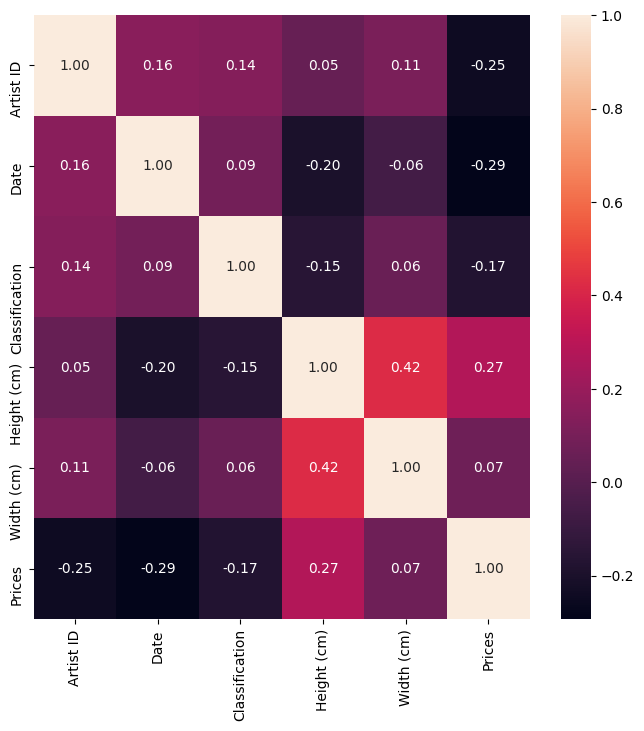

In [11]:
corr_mat = train_data.drop(labels=["Catalogue", "Department"], axis=1).corr()
plt.figure(figsize=(8,8), dpi=100)
sns.heatmap(corr_mat,annot=True, fmt=".2f")
plt.show()

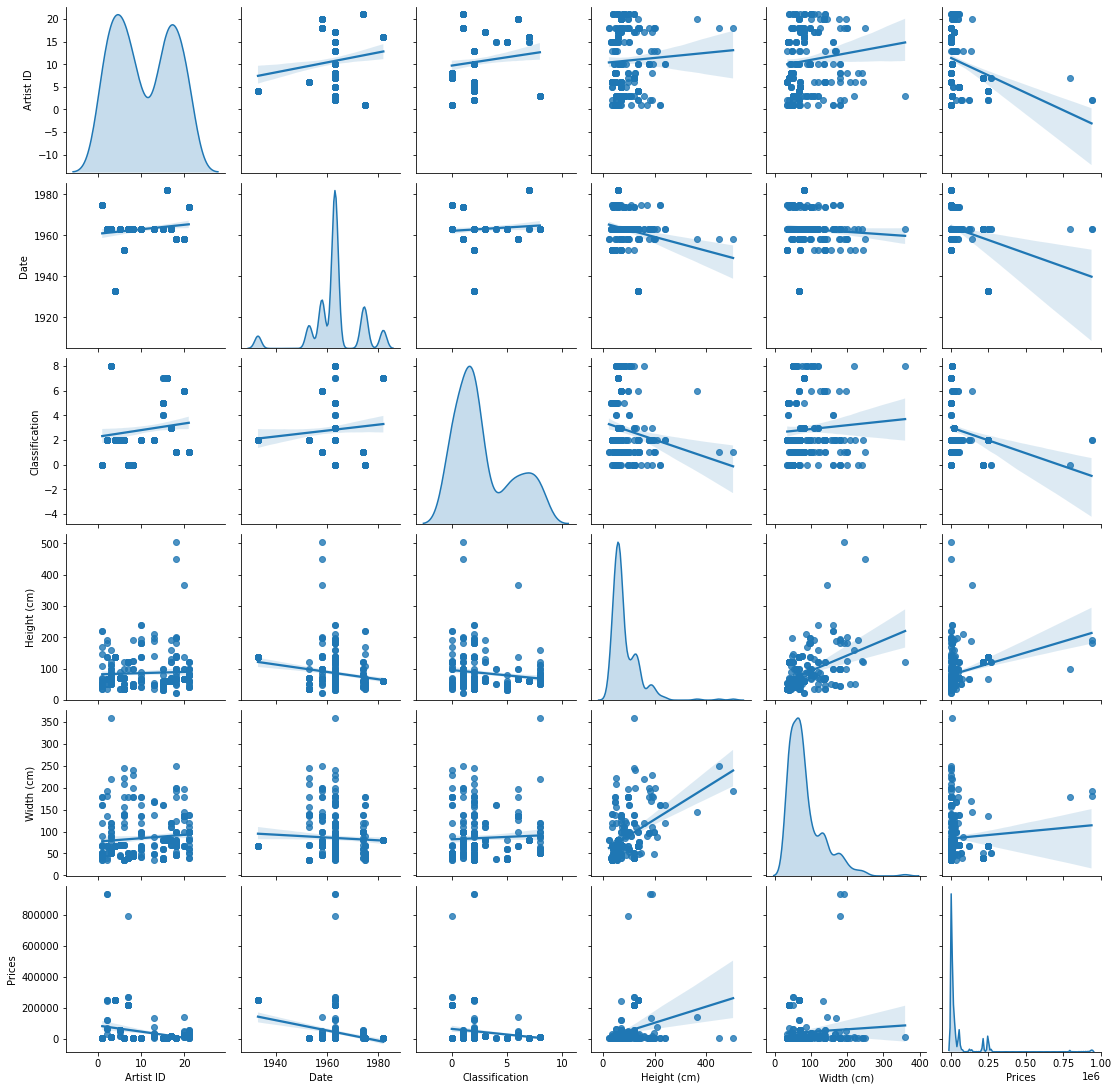

In [15]:
sns.pairplot(data=train_data.drop(labels=["Catalogue", "Department"], axis=1), kind="reg",diag_kind="kde")

<h1><b>4 <span style='color:#f34e26'>|</span> 划分数据集并训练模型</b></h1>

In [37]:
X = train_data.drop(["Prices"],axis=1)
y = train_data["Prices"]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

**训练模型**

In [39]:
from flaml import AutoML
automl = AutoML()

In [40]:
automl.fit(X, y, task="regression",metric='rmse',time_budget=60*1*1)# 1min

[flaml.automl: 08-14 10:21:47] {2444} INFO - task = regression
[flaml.automl: 08-14 10:21:47] {2446} INFO - Data split method: uniform
[flaml.automl: 08-14 10:21:47] {2449} INFO - Evaluation method: cv
[flaml.automl: 08-14 10:21:47] {2568} INFO - Minimizing error metric: rmse
[flaml.automl: 08-14 10:21:47] {2708} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 08-14 10:21:47] {3010} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-14 10:21:47] {3143} INFO - Estimated sufficient time budget=310s. Estimated necessary time budget=2s.
[flaml.automl: 08-14 10:21:47] {3190} INFO -  at 0.0s,	estimator lgbm's best error=86025.1854,	best estimator lgbm's best error=86025.1854
[flaml.automl: 08-14 10:21:47] {3010} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-14 10:21:47] {3190} INFO -  at 0.1s,	estimator lgbm's best error=86025.1854,	best estimator lgbm's best error=86025.1854
[flaml.automl: 08-14 10:21:47

In [41]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best rmse on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 6, 'max_features': 0.662808043114978, 'max_leaves': 51}
Best rmse on validation data: 2.56e+04
Training duration of best run: 0.02701 s


<h1><b>5 <span style='color:#f34e26'>|</span> 获取模型精度</b></h1>

In [42]:
from sklearn.metrics import mean_absolute_error
import pickle
with open("model_data/automl_v2.pkl", "wb") as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

# 加载模型并预测
with open("model_data/automl_v2.pkl", "rb") as f:
    automl = pickle.load(f)

pred = automl.predict(X)
mae = mean_absolute_error(y, pred)
print("MAE: %.3f" % mae)
train_data["Prices"] = pred
train_data.head()

MAE: 522.519


Artist ID    Date  Catalogue  Department  Classification  Height (cm)  \
0          1  1975.0          0           0               0         50.0   
1          1  1975.0          0           0               0         50.0   
2          1  1975.0          0           0               0         50.0   
3          1  1975.0          0           0               0         45.0   
4          1  1975.0          0           0               0         45.0   

   Width (cm)  Prices  
0        50.0  4000.0  
1        50.0  4000.0  
2        50.0  4000.0  
3        45.0  4000.0  
4        45.0  4000.0

<AxesSubplot:xlabel='Prices'>

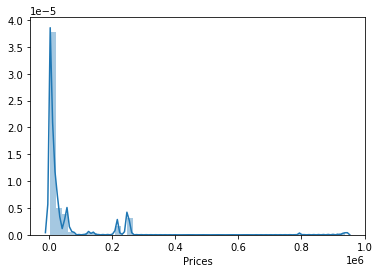

In [43]:
sns.distplot(train_data["Prices"])

In [44]:
train_data.to_csv("preds.csv")